# Demo - Iterative Gaussianization

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
import chex

config.update("jax_enable_x64", False)

import numpy as np
from functools import partial

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
import corner

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [3]:
import pytorch_lightning as pl
from torchvision import transforms
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from rbig_jax.data import GenericDataset

In [48]:
X_, y_ = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

### Preprocessing

In [5]:
def mnist_logit(z, beta=10e-6):
    inter = beta

In [105]:
seed = 123
rng = np.random.RandomState(seed)

X_ += rng.rand(*X_.shape)
X_train = X_ / 256.0

data = X_train[:20_000]

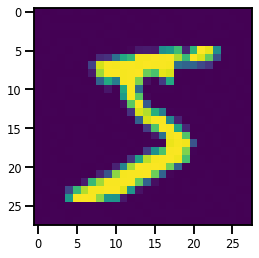

In [106]:
plt.imshow(data[0].reshape((28, 28, 1)))

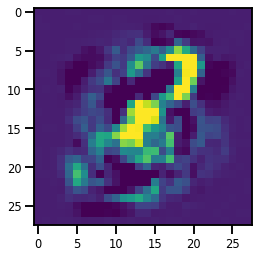

In [88]:
plt.imshow(X_samples[].reshape((28, 28, 1)))

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
# scaler = StandardScaler().fit(X_sub)
# X_sub_scaled = scaler.transform(X_sub)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [107]:
X = np.array(data, dtype=np.float32)

In [108]:
X.min(), X.max()

(1.8998504e-10, 1.0039062)

## Layer I - KDE

In [59]:
from rbig_jax.transforms.kde import InitUniKDETransform, estimate_bw
from rbig_jax.transforms.histogram import InitUniHistTransform

# support_extension = 10
# alpha = 1e-5
# precision = 100
# nbins = None #init_bin_estimator("sqrt") #bins #cott"#int(np.sqrt(X.shape[0]))
# jitted = True

# # initialize histogram transformation
# init_hist_f = InitUniHistTransform(
#     n_samples=X.shape[0],
#     nbins=nbins,
#     support_extension=support_extension,
#     precision=precision,
#     alpha=alpha,
#     jitted=jitted
# )

# KDE Transform
support_extension = 20
alpha = 1e-5
precision = 1_000
bw = "scott"  # estimate_bw(X.shape[0], 1, "scott")

init_hist_f = InitUniKDETransform(
    shape=X.shape, support_extension=support_extension, precision=precision, bw=bw
)

In [60]:
X_u, hist_bijector = init_hist_f.bijector_and_transform(X)

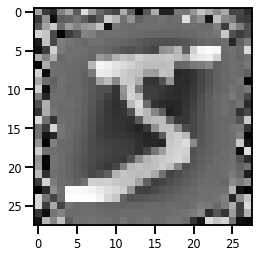

In [61]:
plt.imshow(X_u[0].reshape((28, 28, 1)), cmap="gray")

### Layer II - Logit

In [62]:
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF

# univariate normalization Gaussianization parameters
eps = 1e-5

# initialize histogram transformation
init_icdf_f = InitInverseGaussCDF(eps=eps)

In [63]:
X_g, hist_bijector = init_icdf_f.bijector_and_transform(X_u)

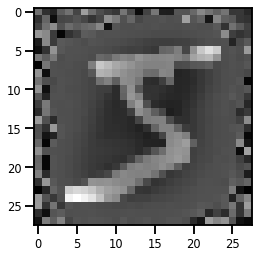

In [64]:
plt.imshow(X_g[0].reshape((28, 28, 1)), cmap="gray")

### Layer III 

In [65]:
from rbig_jax.transforms.rotation import InitPCARotation

# initialize histogram transformation
init_pca_f = InitPCARotation(jitted=True)

In [66]:
X_gr, pca_bijector = init_pca_f.bijector_and_transform(X_g)

In [67]:
X_gr.min()

DeviceArray(-13.545921, dtype=float32)

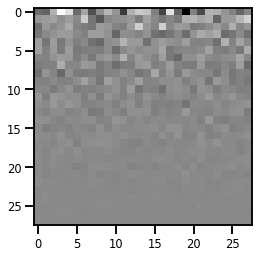

In [68]:
plt.imshow(X_gr[0].reshape((28, 28, 1)), cmap="gray")

## RBIG Algorithm

In [69]:
from rbig_jax.models import RBIG

In [109]:
# a lot of parameters...
support_extension = 10
precision = 1_000
eps = 1e-5
method = "kde"
# Histogram specific params
nbins = None
alpha = 1e-1
# KDE specific params
bw = "scott"

# info reduction loss parameters
max_layers = 30
zero_tolerance = 60
p = 0.25
base = 2

# initialize the max layers parameters
verbose = True
n_layers_remove = 40
interval = 10

# everything (makes it fast...)
jitted = True

In [110]:
X_g, rbig_model = RBIG(
    X=X,
    support_extension=support_extension,
    method=method,
    precision=precision,
    alpha=alpha,
    nbins=nbins,
    bw=bw,
    eps=eps,
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    base=base,
    verbose=verbose,
    n_layers_remove=n_layers_remove,
    interval=interval,
    jitted=jitted,
)

Layer 10 - Cum. Info Reduction: 5363.111 - Elapsed Time: 252.3204
Layer 20 - Cum. Info Reduction: 5369.857 - Elapsed Time: 500.8558
Layer 30 - Cum. Info Reduction: 5376.019 - Elapsed Time: 748.3496
Converged at Layer: 30
Final Number of layers: 30 (Blocks: 10)
Total Time: 748.3540


#### Final Loss

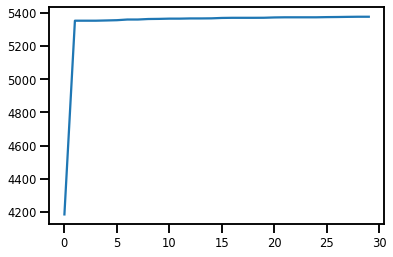

In [111]:
plt.plot(np.cumsum(rbig_model.info_loss))
plt.show()

#### Visualize

In [112]:
X_g[0].shape, X_g[0].min(), X_g[0].max()

((784,),
 DeviceArray(-2.3124485, dtype=float32),
 DeviceArray(2.2543101, dtype=float32))

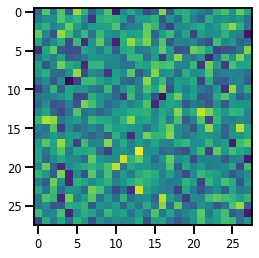

In [113]:
plt.imshow(X_g[0].reshape((28, 28, 1)))

In [114]:
seed = 42

X_samples = rbig_model.sample(seed=seed, n_samples=100)

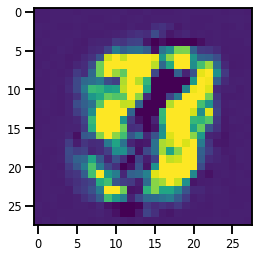

In [117]:
plt.imshow(X_samples[2].reshape((28, 28, 1)))

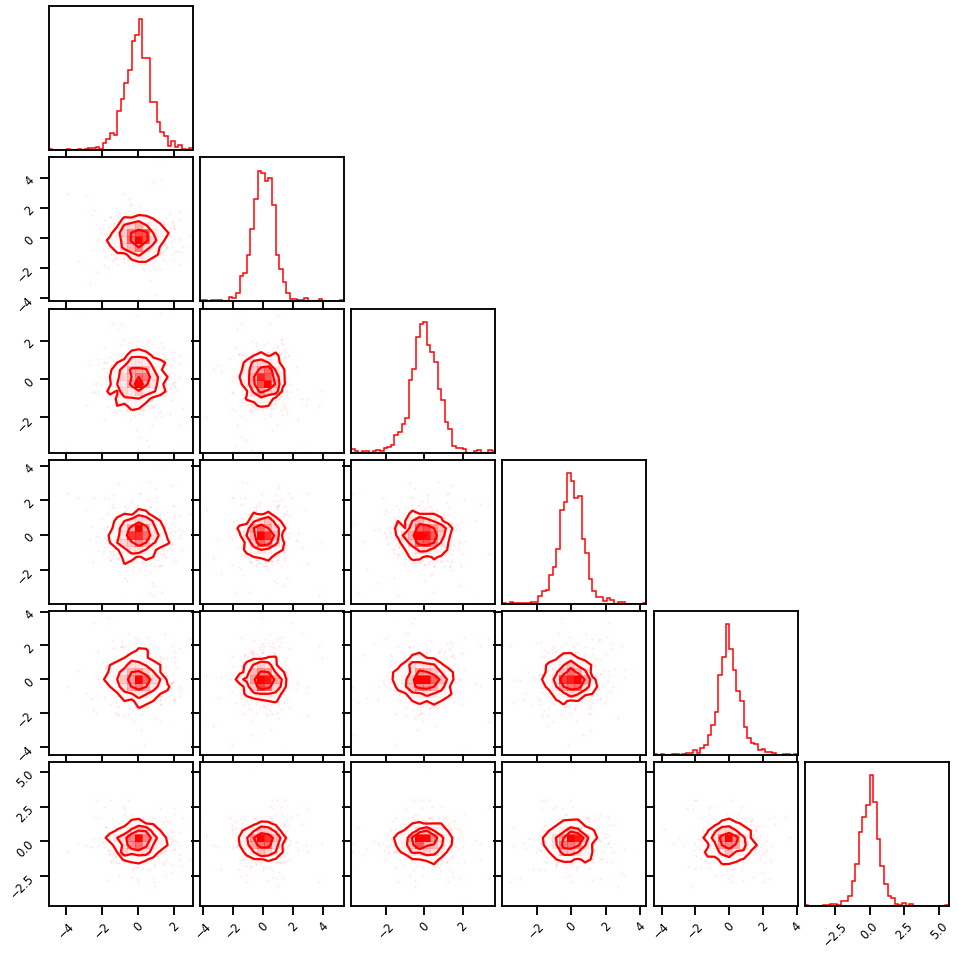

In [81]:
fig = corner.corner(X_g[:, :6], color="red", hist_bin_factor=2)

CPU times: user 4.69 s, sys: 379 ms, total: 5.07 s
Wall time: 4.16 s


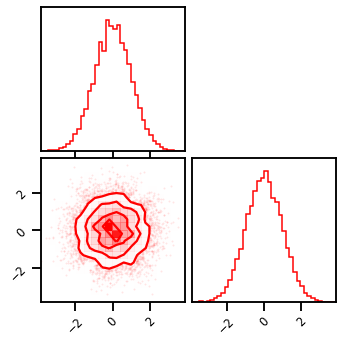

In [55]:
%%time

# inverse cascade
X_g_ = rbig_model.forward(X)

# plot
fig = corner.corner(X_g_, color="red", hist_bin_factor=2)

#### Inverse Transformation

In [82]:
# inverse cascade
X_approx = rbig_model.inverse(X_g)

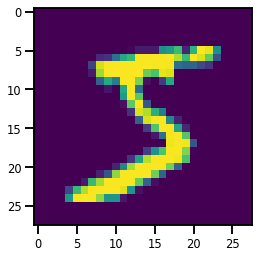

In [83]:
plt.imshow(X_approx[0].reshape((28, 28, 1)))

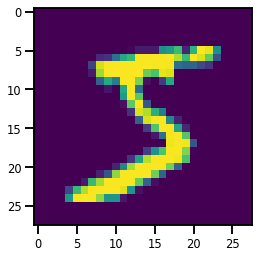

In [84]:
plt.imshow(X[0].reshape((28, 28, 1)))

In [ ]:
# plot
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig = corner.corner(X_approx, color="purple")
fig.suptitle("Original Data (Inverse Transformed)")
plt.show()

#### Density Estimation

In [57]:
from rbig_jax.data import generate_2d_grid

In [58]:
%%time

# generate inputs
xyinput = generate_2d_grid(X, 500, buffer=0.1)

X_log_prob = rbig_model.score_samples(xyinput)

CPU times: user 23.8 s, sys: 2.8 s, total: 26.6 s
Wall time: 6.85 s


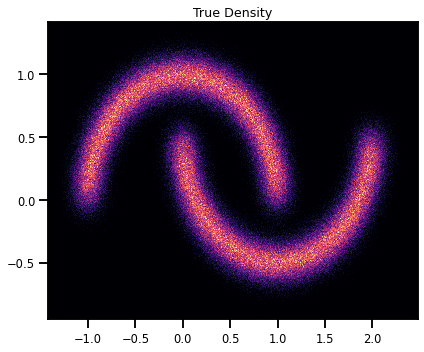

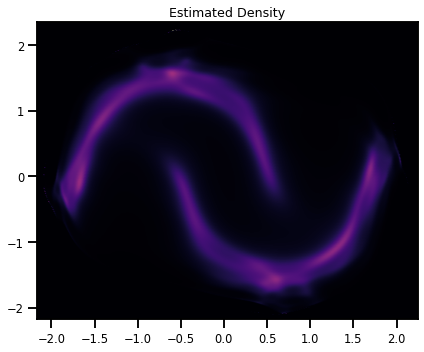

In [79]:
from matplotlib import cm

# # Original Density
# n_samples = 1_000_000
# n_features = 2
# X_plot = load_data(n_samples, 42)
# X_plot = StandardScaler().fit_transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"
# cmap = "Reds"

fig, ax = plt.subplots(figsize=(6, 5))
h = ax.hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax.set_title("True Density")
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
h1 = ax.scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax.set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax.set_title("Estimated Density")
plt.tight_layout()
plt.show()

#### Generate Samples

In [60]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model.sample(seed=seed, n_samples=n_samples)

CPU times: user 5.36 s, sys: 437 ms, total: 5.8 s
Wall time: 2.37 s


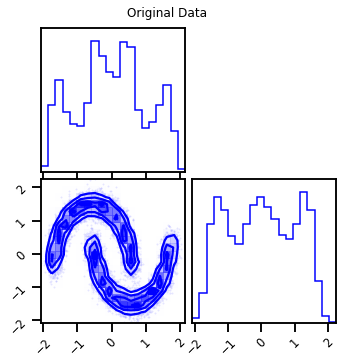

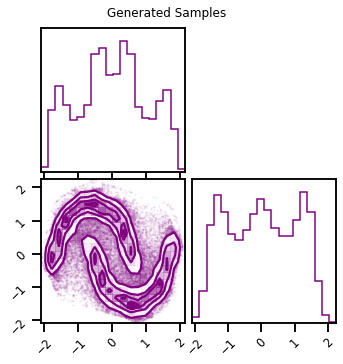

In [61]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Loading and Saving

In [62]:
import pickle

with open("rbig_model.pickle", "wb") as f:
    pickle.dump(rbig_model, f)

### Saving

In [63]:
with open("rbig_model.pickle", "rb") as f:
    rbig_model_ = pickle.load(f)

In [64]:
nll = rbig_model_.score(X)
print(nll)

1.9130434


In [50]:
nll = rbig_model_.score(X)
print(nll)

1.6535428
